In [2]:
# pip install keras-tcn --use-deprecated=legacy-resolver


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, LayerNormalization, MultiHeadAttention, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-05-28 07:04:03.242338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 07:04:04.053921: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 07:04:07.403822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-2

In [2]:
# Load data
xtrain_data = pd.read_csv('XTrain.csv')
ytrain_data = pd.read_csv('YTrain.csv')
engine_data = np.array(pd.read_csv('Engine.csv'))
xtest_data = pd.read_csv('XTest.csv')
ytest_data  = pd.read_csv('YTest.csv')
engine_test_data = np.array(pd.read_csv('Engine_Test.csv'))

In [3]:
# Data saturation function
def saturation_RUL(inp_df, th):
    temp_data = np.array(inp_df)
    temp_data[temp_data > th] = th
    return temp_data

threshold = 130
ytrain_data['Remaining Cycles'] = saturation_RUL(ytrain_data['Remaining Cycles'], threshold)
ytest_data['Remaining Cycles'] = saturation_RUL(ytest_data['Remaining Cycles'], threshold)


In [4]:
# Training data transformation for LSTM
def Feature_Transform(xdata, engdata, window=30):
    n_samp = []
    engines = np.unique(engdata)
    for j in engines:
        local_df = xdata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(np.atleast_2d(local_df.iloc[i:window+i,:]), axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
        n_samp.append(num_samples)
    return input_mat, n_samp            


In [5]:

# RUL transformation for LSTM
def RUL_Transform(ydata, engdata, window=30):
    engines = np.unique(engdata)
    for j in engines:
        local_df = ydata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(local_df.iloc[window+i], axis=0) for i in range(num_samples)]
        if j == engines[0]:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis=0)
    return input_mat.flatten()

window = 30
xtrain, temp = Feature_Transform(xtrain_data.drop('Cycles', axis=1), engine_data, window)
ytrain = RUL_Transform(ytrain_data, engine_data, window)
xtest, n_samp = Feature_Transform(xtest_data.drop('Cycles', axis=1), engine_test_data, window)
ytest = RUL_Transform(ytest_data, engine_test_data, window)


In [6]:

x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=83)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

features = xtrain.shape[2]

(14104, 30, 12) (3527, 30, 12) (14104,) (3527,)


In [7]:
# Define TCN model
def build_tcn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = TCN(return_sequences=True)(inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model


In [8]:
# Define Transformer model
def build_transformer_model(input_shape, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=1)(x)
    x = Dropout(0.1)(x)

    # Transformer Encoder
    x = LayerNormalization(epsilon=1e-6)(x)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(input_shape[1], activation='relu')(x)
    x = x + res

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

In [9]:
# Choose model to build
use_tcn = True  # Set to False to use Transformer model

if use_tcn:
    model = build_tcn_model((window, features))
else:
    model = build_transformer_model((window, features))

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


2024-05-28 07:05:07.904411: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-28 07:05:07.904439: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-28 07:05:07.904458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240527-180959): /proc/driver/nvidia/version does not exist
2024-05-28 07:05:07.906330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations,

In [20]:
# Fit the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=128, verbose=2)


Epoch 1/10
111/111 - 11s - loss: 1.5535 - val_loss: 1.6377 - 11s/epoch - 100ms/step
Epoch 2/10
111/111 - 11s - loss: 1.1083 - val_loss: 1.6312 - 11s/epoch - 99ms/step
Epoch 3/10
111/111 - 11s - loss: 1.2098 - val_loss: 1.5809 - 11s/epoch - 100ms/step
Epoch 4/10
111/111 - 11s - loss: 1.0223 - val_loss: 1.6171 - 11s/epoch - 98ms/step
Epoch 5/10
111/111 - 11s - loss: 0.9154 - val_loss: 1.8736 - 11s/epoch - 103ms/step
Epoch 6/10
111/111 - 11s - loss: 0.8517 - val_loss: 1.2720 - 11s/epoch - 102ms/step
Epoch 7/10
111/111 - 11s - loss: 0.9825 - val_loss: 1.4035 - 11s/epoch - 98ms/step
Epoch 8/10
111/111 - 11s - loss: 0.8621 - val_loss: 1.2884 - 11s/epoch - 98ms/step
Epoch 9/10
111/111 - 11s - loss: 0.8478 - val_loss: 1.5241 - 11s/epoch - 98ms/step
Epoch 10/10
111/111 - 11s - loss: 0.8379 - val_loss: 1.1872 - 11s/epoch - 98ms/step


In [21]:
# Make predictions
ypred = model.predict(xtest)

316/316 [==============================] - 4s 12ms/step


In [22]:
# Evaluate model performance
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('R2: ' + str(r2_score(ytest, ypred)))

RMSE: 18.241297285965143
R2: 0.665661494616482


In [23]:
# Post-process predictions and actual values for plotting and evaluation
wind = 1
n_samp = np.array(n_samp)
samp = {'n_samp': n_samp, 'cumulative': n_samp.cumsum(), 'windowed': n_samp.cumsum()-wind}
samp = pd.DataFrame(samp)

ypred = ypred.flatten()
ytest_trunc = []
ypred_trunc = []
for i in range(len(samp)):
    if samp.iloc[i, 2] > 0:
        ytest_trunc.append(ytest[samp.iloc[i, 2]:samp.iloc[i, 1]])
        ypred_trunc.append(ypred[samp.iloc[i, 2]:samp.iloc[i, 1]])
ypred_truc = np.concatenate(ypred_trunc)
ytest_truc = np.concatenate(ytest_trunc)

In [24]:
# Evaluate truncated predictions
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest_truc, ypred_truc))))
print('R2: ' + str(r2_score(ytest_truc, ypred_truc)))


RMSE: 17.670040135200885
R2: 0.8116877730567833


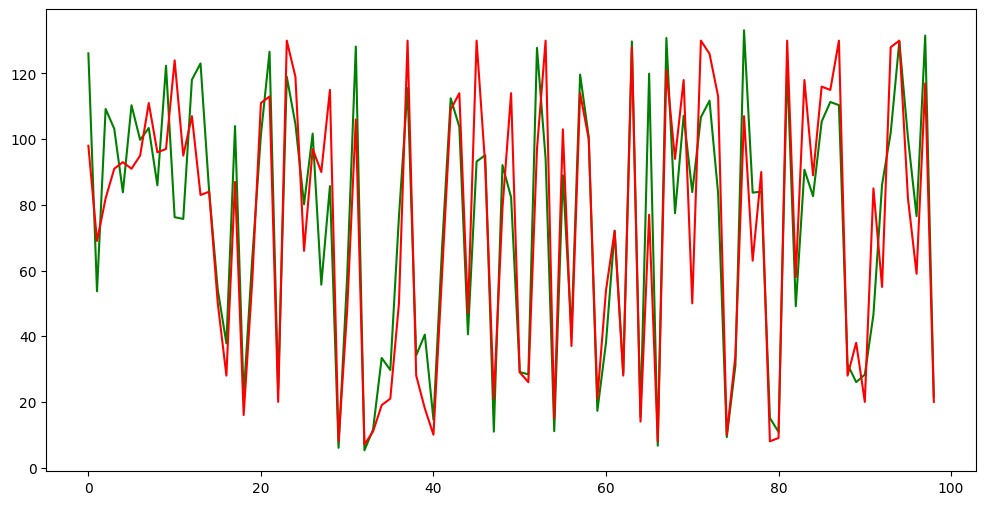

In [25]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(ypred_truc, color='g')
plt.plot(ytest_truc, color='r')
plt.show()

<BarContainer object of 99 artists>

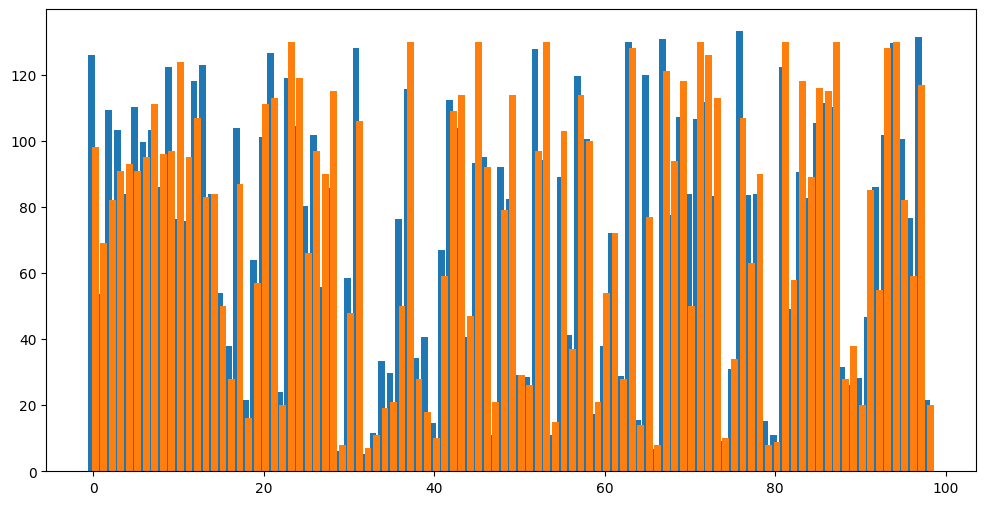

In [26]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(ytest_truc)) 
  
plt.bar(X_axis - 0.2, ypred_truc, label = 'Girls') 
plt.bar(X_axis + 0.2, ytest_truc,label = 'Boys') 
  
#plt.xticks(X_axis, X) 

In [27]:
ytrain_data

,Remaining Cycles
0,130
1,130
2,130
3,130
4,130
...,...
20626,4
20627,3
20628,2
20629,1
